※ Global variables

In [97]:
import torch

gnDataset = 1
gBase_path = 'C:/Users/AdamBao/PycharmProjects/Tool_Classifier/Model'
gnClasses = 5

gDropout_rate = 0.3
gBatch_momentum = 0.7
gLearning_rate = 0.00001
gWeight_decay = 1e-3
gOpt_Momentum = 0.8

gData_batch_size = 8
gEarly_stop_patience = 15
gnEpochs = 100
gbData_augmentation = True

gModel_name = "resnet" # "resnet", "cnn"
gOptimizer_name = "Adam" # , "SGD"
gCriterion_name = "CrossEntropyLoss"


import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


    ※ Widget functions

In [102]:
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle

class ToolDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        if self.transform and not isinstance(img, torch.Tensor):
            img = self.transform(img)
        return img, label

def _load_data(train_data_path):
    raw_data = torch.load(train_data_path)
    data = raw_data['data']
    labels = raw_data['labels']
    return data, labels

def remap_labels(labels, class_mapping):
    return [class_mapping[label] for label in labels]

def load_class_names(filepath):
    with open(filepath, 'r') as file:
        classes = [line.strip() for line in file]
    return classes

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_layers(model):
    layer_count = 0
    for module in model.children():
        if not isinstance(module, nn.Dropout):  # deduct Dropout
            layer_count += 1
    return layer_count


class ToolPlot():
    def __init__(self, model, criterion, device, train_dataloader, test_dataloader, model_num):
        self.model = model
        self.criterion = criterion 
        self.device = device
        self.train_losses = []
        self.validation_losses = []
        self.validation_accuracies = []
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.running_loss = 0.0
        self.model_num = model_num + 1
    
    def init_running_loss(self):
        self.running_loss = 0.0

    def add_loss(self, loss):
        self.running_loss += loss

    def append(self, epoch):
        train_loss = self.running_loss / len(self.train_dataloader)
        validation_loss, validation_accuracy = self._validate()
        self.train_losses.append(train_loss)
        self.validation_losses.append(validation_loss)
        self.validation_accuracies.append(validation_accuracy)
        self._print(epoch, train_loss, validation_loss, validation_accuracy)
        return validation_loss

    def plot(self):
        self._plot_metrics(self.train_losses, self.validation_losses, self.validation_accuracies, self.model_num)
    
    def _print(self, epoch, train_loss, validation_loss, validation_accuracy):
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

    def _validate(self):
        self.model.eval()  # evaluation mode
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        with torch.no_grad():  # disable gradient calculations
            for inputs, labels in self.test_dataloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()
        
        validation_loss = running_loss / len(self.test_dataloader)
        validation_accuracy = correct_predictions / total_samples
        return validation_loss, validation_accuracy

    def _plot_metrics(self, train_losses, validation_losses, validation_accuracies, model_num):
        epochs = range(1, len(train_losses) + 1)

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train Loss', marker='o')
        plt.plot(epochs, validation_losses, label='Validation Loss', marker='o')
        plt.title(f'Model {model_num} Learning per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(epochs, validation_accuracies, label='Validation Accuracy', marker='o', color='green')
        plt.title(f'Model {model_num} Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()    


class EarlyStopping():
    def __init__(self):
        self.best_val_loss = float('inf')
        self.patience_counter = 0

    def isStop(self, validation_loss):
        if validation_loss < self.best_val_loss: #
            self.best_val_loss = validation_loss
            self.patience_counter = 0
        else:
            self.patience_counter += 1
        
        if self.patience_counter >= gEarly_stop_patience: #
            print("Early stopping")
            return True
        else:
            return False

def get_data_augmentation(mode):
    if gbData_augmentation == False:
        return None
    
    if mode == "train":
        return transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5)], p=0.3),
        transforms.RandomApply([transforms.RandomRotation(degrees=15)], p=0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
    else:
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

def load_data(train_data_path, test_data_path):
    train_data, train_labels = _load_data(train_data_path)
    unique_labels = sorted({int(label) for label in train_labels})
    class_mapping = {label: i for i, label in enumerate(unique_labels)}
    print(class_mapping)
    if train_data_path == None:
        train_dataloader = None
    else:
        train_remapped_labels = remap_labels(train_labels, class_mapping)
        transform = get_data_augmentation("train")
        train_dataset = ToolDataset(train_data, train_remapped_labels, transform=transform)
        train_dataloader = DataLoader(train_dataset, batch_size=gData_batch_size, shuffle=True)
    if test_data_path == None:
        test_dataloader = None
    else:
        test_data, test_labels = _load_data(test_data_path)
        remapped_test_labels = remap_labels(test_labels, class_mapping)
        transform = get_data_augmentation("test")
        test_dataset = ToolDataset(test_data, remapped_test_labels, transform=transform)
        test_dataloader = DataLoader(test_dataset, batch_size=gData_batch_size, shuffle=False)

    return train_dataloader, test_dataloader

※ Datasets

In [103]:
train_data_path = f"{gBase_path}/train_data.pth"
test_data_path = f"{gBase_path}/test_data.pth"
print(train_data_path)
print(test_data_path)
train_dataloader, test_dataloader = load_data(train_data_path, test_data_path)
for batch_idx, (inputs, targets) in enumerate(train_dataloader):
    print(f"Batch {batch_idx + 1}:")
    print(f"  Inputs type: {type(inputs)}, size: {inputs.shape}")
    print(f"  Targets type: {type(targets)}, size: {targets.shape}")
    break  # Exit after inspecting the first batch

C:/Users/AdamBao/PycharmProjects/Tool_Classifier/Model/train_data.pth
C:/Users/AdamBao/PycharmProjects/Tool_Classifier/Model/test_data.pth
{172: 0, 684: 1, 789: 2, 823: 3, 938: 4}
Batch 1:
  Inputs type: <class 'torch.Tensor'>, size: torch.Size([8, 3, 64, 64])
  Targets type: <class 'torch.Tensor'>, size: torch.Size([8])


※ Models

1. ResNet18

In [104]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(ImprovedCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Extra Conv Layer
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Conv Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # Extra Conv Layer
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Conv Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # Extra Conv Layer
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # **Global Average Pooling**
        self.gap = nn.AdaptiveAvgPool2d(1)  # Output: (batch_size, 256, 1, 1)

        # Fully Connected Layers
        self.fc_layers = nn.Sequential(
            nn.Linear(256, 128),  # Reduced size
            nn.ReLU(),
            nn.Dropout(0.7),  # Reduced dropout
            nn.Linear(128, num_classes)  # Output layer
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.gap(x)  # Apply Global Average Pooling
        x = x.view(x.size(0), -1)  # Flatten before FC layers
        return self.fc_layers(x)


2. CNN

In [105]:
class CNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Pooling layers
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.pool3 = nn.MaxPool2d(2)
        # Calculate the flattened size by passing dummy input
        """dummy_input = torch.randn(1, 3, 64, 64)
        dummy_output = self.pool2(F.relu(self.bn3(self.conv3(self.pool1(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(dummy_input)))))))))))
        flattened_size = dummy_output.view(1, -1).size(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, 465)
        self.fc2 = nn.Linear(465, num_classes)"""
        
                # Fully connected layers
        self.fc1 = nn.Linear(16384, 465)  # Corrected flattened size
        self.fc2 = nn.Linear(465, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
       
    def forward(self, x):
        # Convolutional layer + ReLU + Batch Normalization
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x) # first pooling
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x) # second pooling
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool3(x)
         
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers + Dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

※ Model Functions

In [106]:
def _get_model(model_name, dropout_rate, batch_momentum):
    print(f"model is {model_name}")
    if model_name == "resnet":
        model = ImprovedCNN(num_classes=gnClasses).to(device)
    elif model_name == "cnn":
        model = CNN(num_classes=gnClasses,
                     dropout_rate=dropout_rate).to(device)


    print(f"Model parameters: {count_parameters(model)}")
    print(f"ModelTotal layers: {count_layers(model)}")
    return model

def _get_optimizer(opname, model, learning_rate, weight_decay, opt_momentum):
    if opname == "Adam":
        return optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif opname == "SGD":
        return optim.SGD(model.parameters(), lr=learning_rate, momentum = opt_momentum, weight_decay=weight_decay)

def _get_criterion(criterion_name):
    if criterion_name == "CrossEntropyLoss":
        return nn.CrossEntropyLoss()
    return nn.CrossEntropyLoss()

def get_models(model_name, optimizer_name, criterion_name):
    model = _get_model(model_name, gDropout_rate, gBatch_momentum)
    optimizer = _get_optimizer(optimizer_name, model, gLearning_rate, gWeight_decay, gOpt_Momentum)
    criterion = _get_criterion(criterion_name)
    
    return model, optimizer, criterion

    
def save_model(model):
    model_saved_path = f"{gBase_path}/Model/model_weights.pth"
    torch.save(model.state_dict(), model_saved_path)
    print(f"Model is saved to: {model_saved_path}")

def load_model(model, m=0):
    model_saved_path = f"{gBase_path}/Model{m+1}/model{m+1}_weights.pth"
    model.load_state_dict(torch.load(model_saved_path))
    print(f"Model{m+1} is loaded from: {model_saved_path}")


In [107]:
model, optimizer, criterion = get_models(gModel_name, gOptimizer_name, gCriterion_name)

model is resnet
Model parameters: 1180741
ModelTotal layers: 3


※ Training / Validating for each model

model is resnet
Model parameters: 1180741
ModelTotal layers: 3
{172: 0, 684: 1, 789: 2, 823: 3, 938: 4}
training begin
Epoch 1, Train Loss: 1.5317, Validation Loss: 1.4189, Validation Accuracy: 0.4245
Epoch 2, Train Loss: 1.4395, Validation Loss: 1.3258, Validation Accuracy: 0.5063
Epoch 3, Train Loss: 1.3854, Validation Loss: 1.2764, Validation Accuracy: 0.5092
Epoch 4, Train Loss: 1.3316, Validation Loss: 1.2215, Validation Accuracy: 0.5740
Epoch 5, Train Loss: 1.2879, Validation Loss: 1.1737, Validation Accuracy: 0.5571
Epoch 6, Train Loss: 1.2546, Validation Loss: 1.1383, Validation Accuracy: 0.5966
Epoch 7, Train Loss: 1.2224, Validation Loss: 1.1083, Validation Accuracy: 0.5853
Epoch 8, Train Loss: 1.2068, Validation Loss: 1.1002, Validation Accuracy: 0.5783
Epoch 9, Train Loss: 1.1618, Validation Loss: 1.0700, Validation Accuracy: 0.5853
Epoch 10, Train Loss: 1.1457, Validation Loss: 1.0152, Validation Accuracy: 0.6389
Epoch 11, Train Loss: 1.1275, Validation Loss: 1.0379, Valid

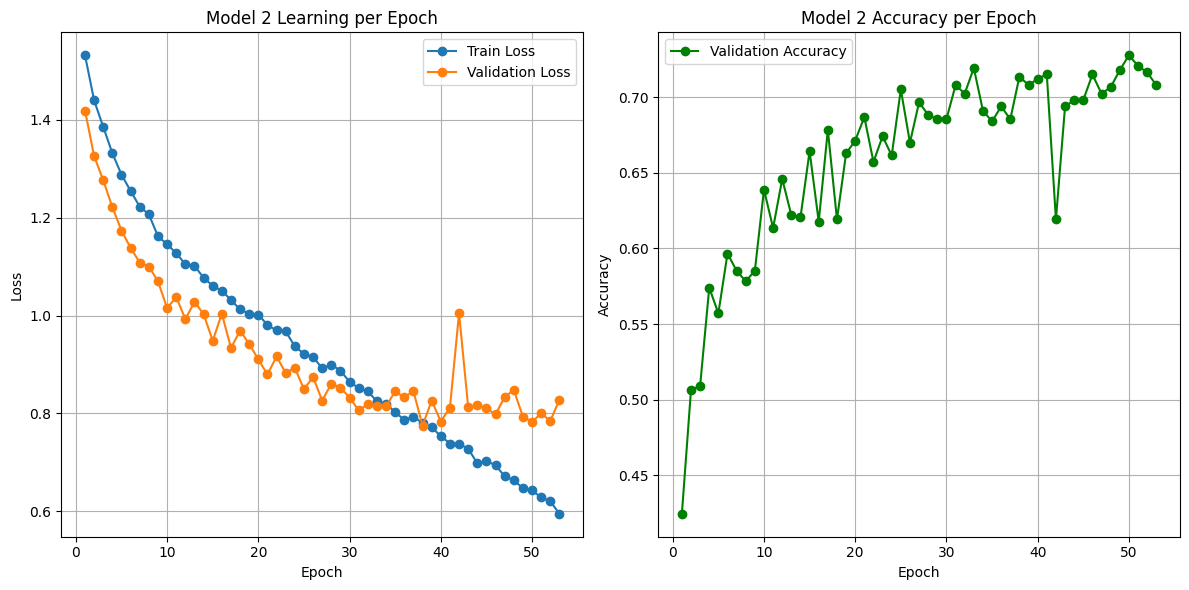

Model is saved to: C:/Users/AdamBao/PycharmProjects/Tool_Classifier/Model/Model/model_weights.pth


In [109]:
model, optimizer, criterion = get_models(gModel_name, gOptimizer_name, gCriterion_name)
train_dataloader, test_dataloader = load_data(train_data_path, test_data_path)
progress = ToolPlot(model, criterion, device, train_dataloader, test_dataloader,1)
es = EarlyStopping()
print("training begin")
for epoch in range(gnEpochs):
        model.train()
        progress.init_running_loss()

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device) # move data to GPU/CPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            progress.add_loss(loss.item())
        
        if es.isStop(progress.append(epoch)):
            break
progress.plot()
save_model(model)
del model
torch.cuda.empty_cache()

